In [36]:
import numpy as np
import pandas as pd
from collections import *
import torch
import torch.nn as nn
from Models.TwoLayerNet import twoLayerNet 
from Hand_model import Hand_model
import matplotlib.pyplot as plt
from torch.autograd import Variable

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 14.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 1

%aimport Models.Solver, Models.ganConv 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Generate data for 6 classes:

# Create an instance of my hand
myhand = Hand_model()

# Create the default posture
default_parameters = myhand.create_posture()

# Parametrize the letters
letters = {} # Dictionary to save the parameters that codify each letter

# Letter A
A = myhand.create_posture()
A.loc['MCP_fe':'PIP','index':'ring']=90
A.loc['TMC_aa','thumb']=-45
letters['A']=A

# Letter B
B = myhand.create_posture()
B.loc['TMC_fe','thumb']=180
letters['B']=B

# Letter C
C = myhand.create_posture()
C.loc['MCP_fe','index':'ring']=30
C.loc['PIP','index':'ring']=60
C.loc['TMC_fe','thumb']=90
C.loc['MCP_fe','thumb']=10
letters['C']=C

# Letter D
D = myhand.create_posture()
D.loc['MCP_fe','little':'thumb']=45
D.loc['PIP','little':'ring']=60
D.loc['TMC_fe','thumb'] = 90
letters['D']=D

# Letter E
E = myhand.create_posture()
E.loc['MCP_fe','index':'thumb']=90
E.loc['PIP','index':'ring']=90
E.loc['TMC_aa','thumb']=-90
letters['E']=E

# Initialize variables
n_samples = 1
variance = 25 # For noise: v degrees in all the angles  
n_letters = len(letters)

# Number of parameters
array = default_parameters.as_matrix().ravel()
array = array[~np.isnan(array)]
n_params = len(array)

# Create the parameters structure
params = np.zeros((n_letters*n_samples,n_params))
# labels = np.zeros(n_letters*n_samples)
labels = np.zeros((n_letters*n_samples,n_letters))

l=0    
for key, letter in letters.items():

    # Params
    new_params = myhand.create_samples(letter,n_samples,variance)
    params[(l*n_samples):(l*n_samples+n_samples),:] = new_params

    # Labels
    labels[(l*n_samples):(l*n_samples+n_samples),l]=1
    l+=1
    

D:\anaconda\envs\forceNet\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\tetia\PycharmProjects\NISE_GAN\NISE_project\Hand_model.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  array = letter.as_matrix().ravel()


In [50]:
# Run the trained feedforward model to generate 6 labels
net = torch.load('Trained/twoLayer.pth')

y_pred = net(torch.from_numpy(np.float32(params)))
_, labels_check = torch.max(y_pred,1) # Classes

print(labels_check)

tensor([1, 0, 1, 4, 4])


In [51]:
# Generator has the following encoding of classes:0-D, 1-C, 2-A, 3-B, 5-E (4-F - not included to analysis)

dict_decode = {0:2, 1:3, 2:1, 3:0, 4:5}
labels_check = labels_check.numpy()
for label in range(labels_check.shape[0]):
    labels_check[label] = dict_decode[labels_check[label]]
    
labels_check

array([3, 2, 3, 5, 5], dtype=int64)

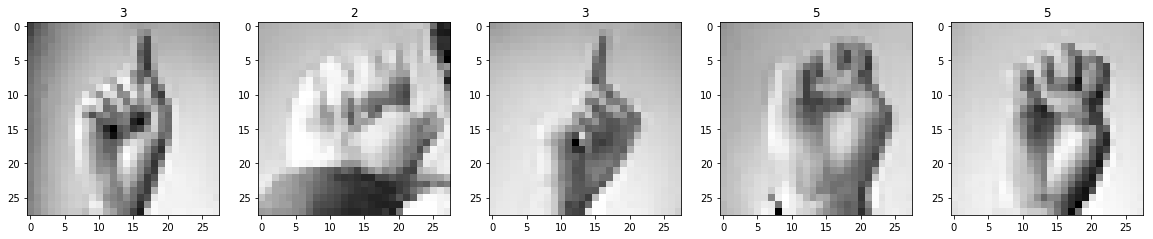

In [52]:
# Run Generator to generate respective images

   
#Parameters for GAN 
parameters={
'latent_dim': 100, #dimensionality of the latent space
'n_classes': 6, #number of classes for dataset
'img_size': 28, #size of each image dimension
'channels': 1, #number of image channels
}

generator = torch.load('Trained/generator_conv_short.pth')

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator.cuda()

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# Sample noise and labels as generator input
z = Variable(FloatTensor(np.random.normal(0, 1, (5, parameters['latent_dim']))))

# Generate images
generator.eval()
check_imgs = generator(z, Variable(LongTensor(labels_check)))

fig = plt.figure(figsize=(20,20))
for show in range(5):
    ax = fig.add_subplot(1,5,show+1)
    ax.imshow(check_imgs.cpu().detach().numpy()[show,:,:], cmap='gray')
    plt.title(str(labels_check[show]))